### Loading and Preparing data

In [39]:
# Load and prepare the data
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("../../data/processed/preprocessed_incident_event_scaled_svm_mlp.csv")

In [40]:
# Shape of the dataset
print(f"Total rows: {df.shape[0]}")
print(f"Total columns: {df.shape[1]}")

# All column names
print("All columns:")
print(df.columns.tolist())

Total rows: 141707
Total columns: 37
All columns:
['reassignment_count', 'reopen_count', 'sys_mod_count', 'impact', 'knowledge', 'u_priority_confirmation', 'opened_month', 'opened_weekend', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'number_freq', 'caller_id_freq', 'assigned_to_freq', 'opened_by_freq', 'resolved_by_freq', 'u_symptom_freq', 'closed_code_freq', 'location_freq', 'category_freq', 'subcategory_freq', 'assignment_group_freq', 'urgency_priority_score', 'incident_state_Awaiting Evidence', 'incident_state_Awaiting Problem', 'incident_state_Awaiting User Info', 'incident_state_Awaiting Vendor', 'incident_state_Closed', 'incident_state_New', 'incident_state_Resolved', 'notify_Send Email', 'contact_type_Email', 'contact_type_IVR', 'contact_type_Phone', 'contact_type_Self service', 'time_to_resolution_log']


### Correlation with time_to_resolution_log

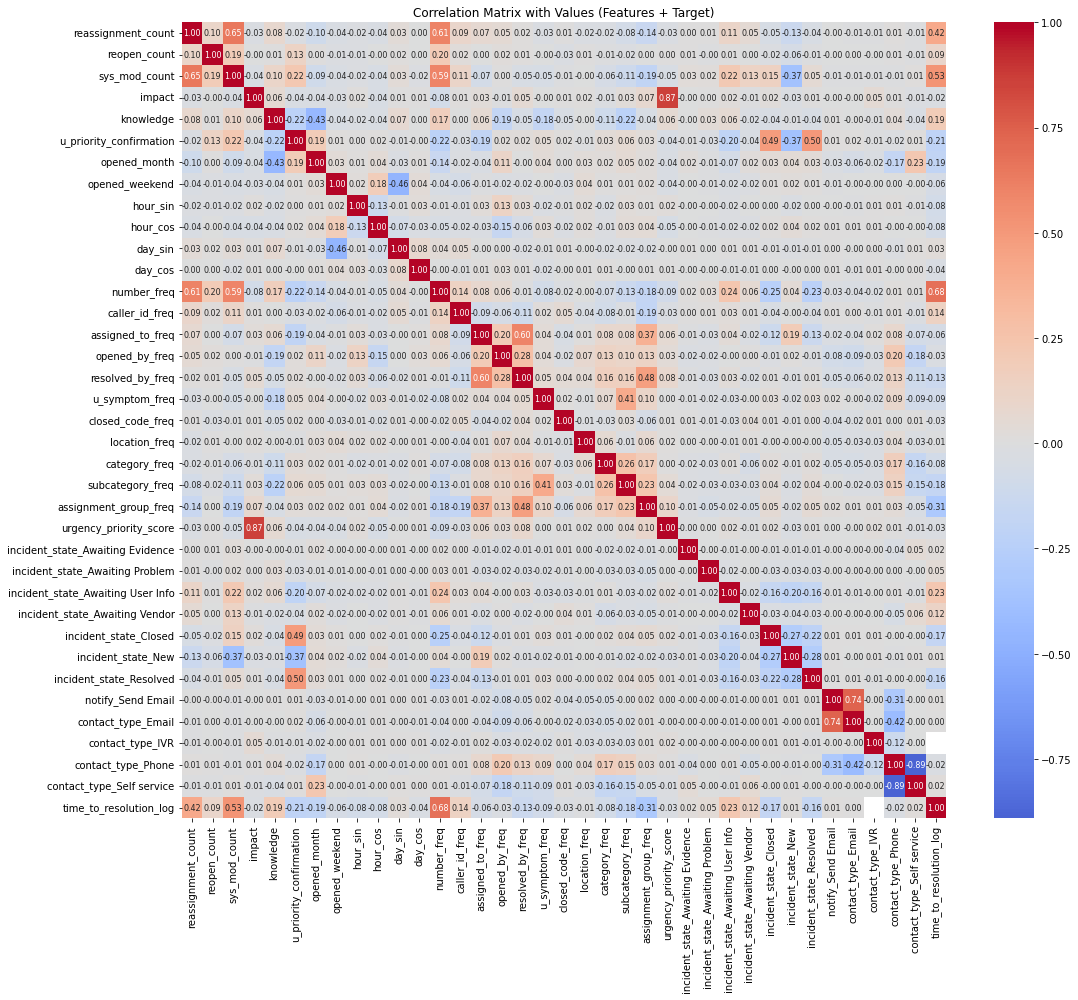

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

# Plotting heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8}
)
plt.title("Correlation Matrix with Values (Features + Target)")
plt.tight_layout()
plt.show()



### Feature Engineering

- We computed the Pearson correlation between all numeric features and the target variable time_to_resolution_log.
- Features with a correlation coefficient below 0.1 are considered weak predictors and should be removed from the dataset. These included frequency encodings (e.g., caller_id_freq, category_freq), time-based encodings (hour_sin, day_cos), and several one-hot encoded incident states and contact types.
- These features showed little to no linear relationship with the target and could introduce noise or complexity into the model without meaningful contribution. This pruning step simplifies the input space and can improve model interpretability and generalization.

In [42]:
features_to_drop = [
    'knowledge', 'u_priority_confirmation', 'opened_weekend', 'hour_sin', 'hour_cos',
    'day_sin', 'day_cos', 'location_freq', 'category_freq', 'subcategory_freq',
    'closed_code_freq', 'u_symptom_freq', 'caller_id_freq', 'incident_state_Awaiting Evidence',
    'incident_state_Awaiting Problem', 'incident_state_Awaiting User Info',
    'incident_state_Awaiting Vendor', 'incident_state_New', 'urgency_priority_score',
    'notify_Send Email', 'contact_type_Email', 'contact_type_Phone',
    'contact_type_IVR', 'contact_type_Self service', 'opened_by_freq', 'assigned_to_freq', 'reassignment_count'
]

df = df.drop(columns=features_to_drop)

**Dropped Features – Summary**

1. Very Low Correlation (< 0.05):  
Features like knowledge, u_priority_confirmation, opened_weekend, notify_Send Email, and urgency_priority_score were dropped due to negligible or no correlation with the target variable.

2. Time Encodings (hour/day sin/cos):  
Encodings like hour_sin, hour_cos, day_sin, and day_cos showed no predictive value for resolution time and were dropped.

3. Weak Frequency Encodings:  
Features such as caller_id_freq, location_freq, category_freq, and subcategory_freq had low variance in relation to resolution time and were excluded.

4. Uninformative Contact Channels:  
contact_type_Email, contact_type_Phone, contact_type_IVR, and contact_type_Self service had very weak or no correlation and added unnecessary categorical noise.

5. Low-Impact Incident States:  
One-hot encoded incident states like incident_state_New, Awaiting Evidence, Awaiting Vendor, etc., showed no significant correlation and were removed.

6. Redundant Frequency Features:  
assigned_to_freq and opened_by_freq were dropped due to very low correlation, while stronger related features like resolved_by_freq were retained.

7. Multicollinearity with Top Feature:  
reassignment_count was dropped due to high correlation (r = 0.61) with number_freq, which had a stronger relationship with the target.

#### Updated Correlation matrix

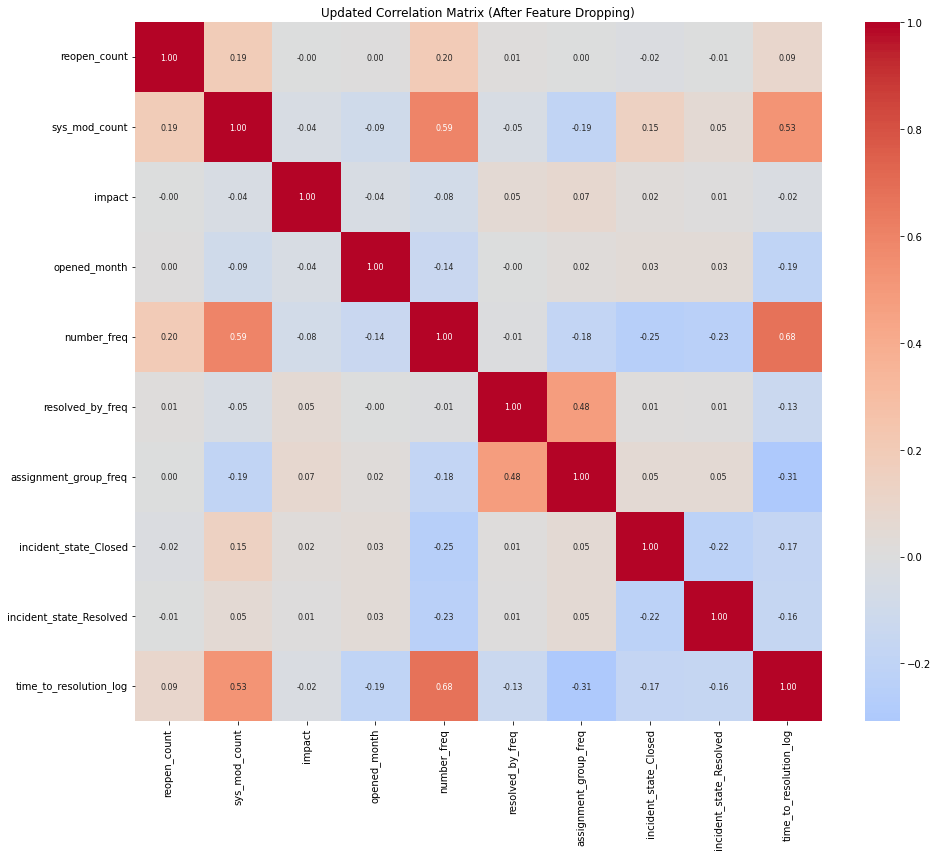

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

# Plotting updated heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8}
)
plt.title("Updated Correlation Matrix (After Feature Dropping)")
plt.tight_layout()
plt.show()


In [44]:
# Dropping rows where target is missing
df = df.dropna(subset=["time_to_resolution_log"])
df.head()

,reopen_count,sys_mod_count,impact,opened_month,number_freq,resolved_by_freq,assignment_group_freq,incident_state_Closed,incident_state_Resolved,time_to_resolution_log
0,-0.10573,-1.016534,-0.012218,-1.909515,-0.886579,-2.424589,-1.255453,-0.462661,-0.471249,2.417401
1,-0.10573,-0.533365,-0.012218,-1.909515,-0.886579,-2.424589,-1.255453,-0.462661,2.122020,2.417401
2,-0.10573,-0.291780,-0.012218,-1.909515,-0.886579,-2.424589,-1.255453,-0.462661,2.122020,2.417401
3,-0.10573,-0.050196,-0.012218,-1.909515,-0.886579,-2.424589,-1.255453,2.161408,-0.471249,2.417401
4,-0.10573,-1.016534,-0.012218,-1.909515,0.468326,-0.438353,1.207647,-0.462661,-0.471249,3.407842


In [45]:
# Separating features and target
X = df.drop(columns=["time_to_resolution_log"])
y = df["time_to_resolution_log"]

In [46]:
# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
feature_names = X.columns  # Save the column names
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [48]:
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 110852
Testing samples: 27714


In [49]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(max_iter=500, early_stopping=True, validation_fraction=0.1, random_state=42))
])

param_dist = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': uniform(0.0001, 0.01),
    'mlp__learning_rate': ['constant', 'adaptive']
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=6,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('mlp',
                                              MLPRegressor(early_stopping=True,
                                                           max_iter=500,
                                                           random_state=42))]),
                   n_iter=6, n_jobs=-1,
                   param_distributions={'mlp__activation': ['relu', 'tanh'],
                                        'mlp__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001DAEA61CA60>,
                                        'mlp__hidden_layer_sizes': [(50,),
                                                                    (100,),
                                                                    (50, 50)],
                                        'mlp__learning_rate': ['constant',
                                                               'adaptive']},
                   random_state=42, scoring='r2', verbose=1)

### Training MLP Model

In [50]:
# Print best results
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validated R² Score:", random_search.best_score_)

Best Parameters: {'mlp__activation': 'tanh', 'mlp__alpha': 0.006086584841970367, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__learning_rate': 'adaptive'}
Best Cross-Validated R² Score: 0.7040448048633468


**Best Parameters and Cross-Validation Score:**

After performing hyperparameter tuning using **RandomizedSearchCV**, the optimal configuration for the `MLPRegressor` was:

- **Activation Function**: `tanh` — enables the model to learn complex non-linear relationships.
- **Alpha (L2 Regularization)**: `0.0061` — helps prevent overfitting by penalizing large weights.
- **Hidden Layer Sizes**: `(50, 50)` — a two-layer architecture with 50 neurons in each layer.
- **Learning Rate**: `adaptive` — adjusts learning rate based on model performance during training.

This configuration achieved a **best cross-validated R² score of 0.704**, indicating that approximately **70.4%** of the variance in the target variable is explained by the model across validation folds.


In [51]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

### Evaluation Metrics

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.8981
Mean Squared Error (MSE): 1.5188
R² Score: 0.7096


##### Metrics plot

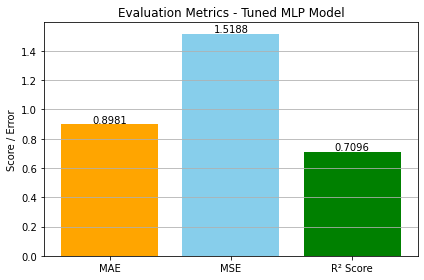

In [53]:
import matplotlib.pyplot as plt

metrics = {'MAE': mae, 'MSE': mse, 'R² Score': r2}

plt.bar(metrics.keys(), metrics.values(), color=['orange', 'skyblue', 'green'])
plt.title("Evaluation Metrics - Tuned MLP Model")
plt.ylabel("Score / Error")
plt.grid(axis='y')
for key, value in metrics.items():
    plt.text(key, value + 0.01, f"{value:.4f}", ha='center')
plt.tight_layout()
plt.show()



**Observation:**

The bar chart summarizes the evaluation metrics for the trained MLP regression model:

1. Mean Squared Error (MSE): 1.5188  
Indicates the average squared difference between actual and predicted values. A lower MSE is preferred, and this value reflects a moderate level of error.

2. Mean Absolute Error (MAE): 0.8981   
Represents the average absolute difference between predicted and actual resolution times (in log scale). This suggests that on average, predictions are off by less than 1 unit, which is reasonable for this context.

3. R² Score: 0.7096  
This means the model explains approximately 71% of the variance in the target variable. It shows that the MLP model is capturing most of the important patterns in the data, though there is still room for improvement.

### Visualize Model Predictions

#### 1. Binned Line Plot – Mean Prediction per Bin

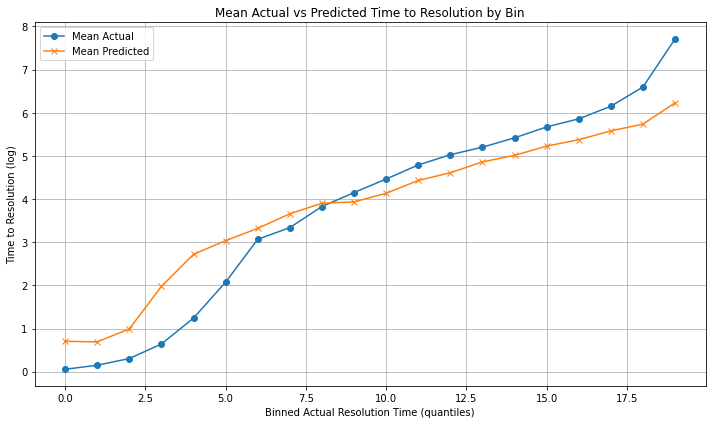

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results_df['Actual_bin'] = pd.qcut(results_df['Actual'].to_numpy(), q=20, duplicates='drop')
binned_means = results_df.groupby('Actual_bin')[['Actual', 'Predicted']].mean()

plt.figure(figsize=(10, 6))
plt.plot(binned_means['Actual'].to_numpy(), label='Mean Actual', marker='o')
plt.plot(binned_means['Predicted'].to_numpy(), label='Mean Predicted', marker='x')
plt.xlabel('Binned Actual Resolution Time (quantiles)')
plt.ylabel('Time to Resolution (log)')
plt.title('Mean Actual vs Predicted Time to Resolution by Bin')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation:**
The plot shows a generally increasing trend for both actual and predicted means across the quantile bins. The predicted values closely follow the actual values for most of the range, especially in the middle bins. However, in the extreme low and high quantiles, the model slightly underestimates resolution times. This suggests that while the model captures the overall pattern well, it tends to smooth out more extreme cases — a common behavior for MLPs trained on log-transformed targets.

#### 2. Distribution Comparison – Actual vs Predicted

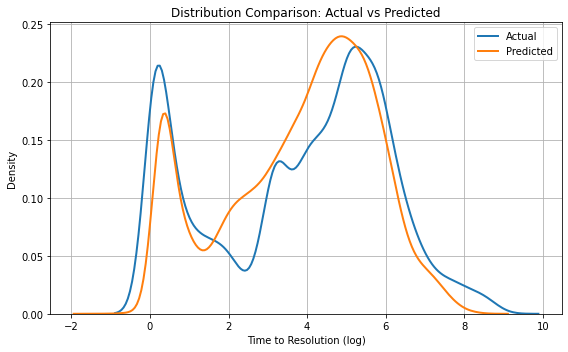

In [55]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.kdeplot(results_df['Actual'], label='Actual', linewidth=2)
sns.kdeplot(results_df['Predicted'], label='Predicted', linewidth=2)
plt.title("Distribution Comparison: Actual vs Predicted")
plt.xlabel("Time to Resolution (log)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Observation:**  

The predicted and actual distributions are broadly aligned, indicating that the model captures the overall trend of resolution times well. However, the predicted curve is slightly shifted left in some regions, suggesting a mild underestimation of longer resolution times. The model performs best in the common resolution range but underrepresents extreme values.

#### 3. Top Feature Influences (Permutation MAE)

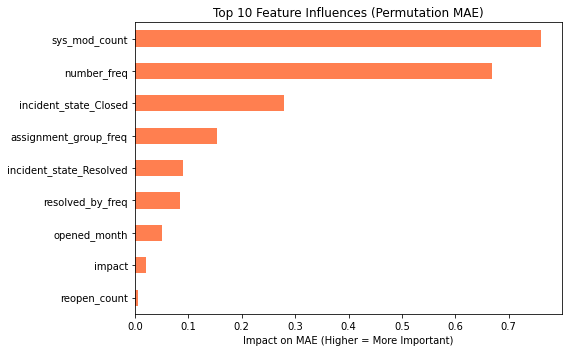

In [56]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_model, X_test, y_test, scoring='neg_mean_absolute_error', n_repeats=10, random_state=42)

# Visualizing top influential features
importances = pd.Series(result.importances_mean, index=X_test.columns)
top10 = importances.abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
top10.plot(kind='barh', color='coral')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Influences (Permutation MAE)")
plt.xlabel("Impact on MAE (Higher = More Important)")
plt.tight_layout()
plt.show()


**Observation:**  

The plot shows that sys_mod_count and number_freq are the most influential features, significantly affecting prediction error when permuted. Features like incident_state_Closed and assignment_group_freq also contribute meaningfully. In contrast, features such as reopen_count, impact, and opened_month have minimal impact on model performance.

### Saving Best Model

In [59]:
import joblib
joblib.dump(best_model, '../../models/Regression_MLP_incident_event_model.pkl')

['../../models/mlp_regressor_best.pkl']

### Conclusion

In this experiment, we developed a regression model using a **Multi-Layer Perceptron (MLP)** to predict the time to resolution for incident management tasks. The workflow involved systematic preprocessing, correlation-based feature selection, and hyperparameter tuning via **RandomizedSearchCV**.

#### 🔹 Key Steps and Takeaways:

- **Feature Engineering**:  
  Weakly correlated and collinear features were removed based on a Pearson correlation threshold of ±0.1 to improve model interpretability and reduce overfitting.

- **Model Training**:  
  A baseline MLP was enhanced using a `Pipeline` and hyperparameter optimization. Tuned parameters included:
  - **Activation**: `tanh`
  - **Hidden Layers**: `(50, 50)`
  - **Alpha (L2 regularization)**: `0.0061`
  - **Learning Rate**: `adaptive`

- **Model Evaluation**:
  - **Mean Absolute Error (MAE)**: `0.8981`
  - **Mean Squared Error (MSE)**: `1.5188`
  - **R² Score**: `0.7096`

  These results indicate that the final model explains approximately **71% of the variance** in resolution time while maintaining relatively low prediction error.

- **Feature Insights**:  
  Permutation importance revealed key features such as `sys_mod_count` and `number_freq` as most influential in determining resolution time.

Overall, this experiment demonstrates the effectiveness of combining **neural networks**, **automated tuning**, and **thoughtful feature engineering** in addressing real-world regression problems within IT service management.
